# Social Prediction Analysis with multiple regression


1. run omnibus anova on all six beta maps to identify significant voxels
2. identify significant clusters from the omnibus anova
3. Extract average beta per cluster
4. Run regression model using prior vs feedback to determine the factors driving each cluster
5. Run regression model using social_only, pattern_only, PE_only, consistent_only to determine the factors driving each cluster
6. Color code the clusters for the driving factors and plot

*Yiyu Wang 2024 September*


In [22]:
import os

import glob
import nibabel as nib
import numpy as np
import pandas as pd
import copy

import nilearn
from nilearn.image import smooth_img, resample_to_img, new_img_like, math_img, concat_imgs, get_data, mean_img
from nilearn import image
from nilearn import plotting
from nilearn.masking import apply_mask
from nilearn.maskers import NiftiMasker
from nilearn.glm.second_level import SecondLevelModel
from nilearn.reporting import get_clusters_table
from nilearn.glm import threshold_stats_img
from scipy.stats import norm
from nilearn.maskers import NiftiLabelsMasker
from nilearn.datasets import load_mni152_gm_mask,load_mni152_wm_mask,fetch_surf_fsaverage


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import gzip
import math

import seaborn as sns
import matplotlib.pyplot as plt
from os.path import join
from itertools import product


In [2]:
# local directory set up
gm_mask_img = nib.load('../masks/gm_mask_icbm152_brain.nii.gz')

subjects_list = pd.read_csv('../Data/included_SocialPred_subjects.csv', header=None)
subjects_list = subjects_list[0].values.tolist()
sample_n = len(subjects_list)
print("subjects in this analysis:")
print(subjects_list)
print(f"**** n = {sample_n} *****" )


TR = .001
N_TR = 675
TR_Length = 0.8
TR_IN_MS = int(TR_Length/TR)

fwhm = 0


subjects in this analysis:
[152, 179, 154, 158, 173, 153, 159, 174, 162, 145, 143, 181, 144, 169, 146, 167, 161, 182, 147, 166, 160, 185, 170, 176, 151, 157, 171, 177, 150, 156]
**** n = 30 *****


In [3]:
# omnibus anova test in design matrix


beta_dir = '/Users/yiyuwang/Downloads/model_FBvOBS_SubjectivePrior_202409_model1/1stLvl/'
second_level_res_dir = '/Users/yiyuwang/Downloads/model_FBvOBS_SubjectivePrior_202409_model1/omnibus_anova_F/'
if not os.path.isdir(second_level_res_dir):
    os.mkdir(second_level_res_dir)


vmax = 5
cluster_thre = 30
p_val = 0.05
p_unc = norm.isf(p_val)

p001 = 0.001
p001_unc = norm.isf(p001)

alpha = 0.05


# Regression model with an omnibus ANOVA design

In [4]:
# design matrix for one sample test

file_list = []

obs_pattern, obs_social, fb_pattern_congruent, fb_social_congruent, fb_pattern_PE, fb_social_PE = [], [], [], [], [], []
for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*z_score*obs_Pattern*.nii.gz')
    file_list.append(file_name[0])
    obs_pattern.append(1)
    obs_social.append(0)
    fb_pattern_congruent.append(0)
    fb_social_congruent.append(0)
    fb_pattern_PE.append(0)
    fb_social_PE.append(0)

for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*z_score*obs_Social*.nii.gz')
    file_list.append(file_name[0])
    obs_pattern.append(0)
    obs_social.append(1)
    fb_pattern_congruent.append(0)
    fb_social_congruent.append(0)
    fb_pattern_PE.append(0)
    fb_social_PE.append(0)
    

for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*z_score*fb_Social_Congruent*.nii.gz')
    file_list.append(file_name[0])
    obs_pattern.append(0)
    obs_social.append(0)
    fb_pattern_congruent.append(0)
    fb_social_congruent.append(1)
    fb_pattern_PE.append(0)
    fb_social_PE.append(0)

for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*z_score*fb_Social_PE*.nii.gz')
    file_list.append(file_name[0])
    obs_pattern.append(0)
    obs_social.append(0)
    fb_pattern_congruent.append(0)
    fb_social_congruent.append(0)
    fb_pattern_PE.append(0)
    fb_social_PE.append(1)

for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*z_score*fb_Pattern_Congruent*.nii.gz')
    file_list.append(file_name[0])
    obs_pattern.append(0)
    obs_social.append(0)
    fb_pattern_congruent.append(1)
    fb_social_congruent.append(0)
    fb_pattern_PE.append(0)
    fb_social_PE.append(0)

for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*z_score*fb_Pattern_PE*.nii.gz')
    file_list.append(file_name[0])
    obs_pattern.append(0)
    obs_social.append(0)
    fb_pattern_congruent.append(0)
    fb_social_congruent.append(0)
    fb_pattern_PE.append(1)
    fb_social_PE.append(0)

second_level_input = file_list

design_columns = ['obs_pattern', 'obs_social', 'fb_pattern_congruent', 'fb_social_congruent', 'fb_pattern_PE', 'fb_social_PE']

X = pd.concat([pd.Series(obs_pattern), 
               pd.Series(obs_social),
               pd.Series(fb_pattern_congruent),
               pd.Series(fb_social_congruent),
               pd.Series(fb_pattern_PE),
               pd.Series(fb_social_PE)], axis=1)
X.columns= design_columns

second_level_input = file_list
second_level_model = SecondLevelModel()
second_level_model = second_level_model.fit(second_level_input,
                                            design_matrix=X)

plotting.plot_design_matrix(X, output_file=join(second_level_res_dir, f'design_matrix.png'))

# test to make sure no difference between how the contrast is defined
# omnibus_contrast = np.array([[1, -1, 0, 0, 0, 0],   
#                               [1, 0, -1, 0, 0, 0],   
#                               [1, 0, 0, -1, 0, 0],   
#                               [1, 0, 0, 0, -1, 0],
#                               [1, 0, 0, 0, 0, -1]])  
omnibus_contrast = np.array([[0, -1, 0, 0, 0, 1],   
                              [0, 0, -1, 0, 0, 1],   
                              [0, 0, 0, -1, 0, 1],   
                              [0, 0, 0, 0, -1, 1],
                              [-1, 0, 0, 0, 0, 1]])  
# check rank of the contrast matrix for singular matrix
rank_omnibus_contrast = np.linalg.matrix_rank(omnibus_contrast)
print(f"Rank of the omnibus contrast matrix: {rank_omnibus_contrast}")

group_res = second_level_model.compute_contrast(omnibus_contrast,output_type='all', second_level_stat_type='F')
for stats_name in group_res.keys():
    res = group_res[stats_name]
    nii_file_path = second_level_res_dir + f'omnibus_anova_{stats_name}.nii.gz'
    print(f"saving {nii_file_path}")
    nib.save(res, nii_file_path)

Rank of the omnibus contrast matrix: 5
saving /Users/yiyuwang/Downloads/model_FBvOBS_SubjectivePrior_202409_model1/omnibus_anova_F/omnibus_anova_z_score.nii.gz
saving /Users/yiyuwang/Downloads/model_FBvOBS_SubjectivePrior_202409_model1/omnibus_anova_F/omnibus_anova_stat.nii.gz
saving /Users/yiyuwang/Downloads/model_FBvOBS_SubjectivePrior_202409_model1/omnibus_anova_F/omnibus_anova_p_value.nii.gz
saving /Users/yiyuwang/Downloads/model_FBvOBS_SubjectivePrior_202409_model1/omnibus_anova_F/omnibus_anova_effect_size.nii.gz
saving /Users/yiyuwang/Downloads/model_FBvOBS_SubjectivePrior_202409_model1/omnibus_anova_F/omnibus_anova_effect_variance.nii.gz


In [5]:
from nilearn.image import load_img
all_sub_z = load_img(second_level_input)

In [6]:
group_res_zscore = nib.load(f'{second_level_res_dir}omnibus_anova_z_score.nii.gz')

thresholded_map, second_level_threshold = threshold_stats_img(group_res_zscore, 
                                alpha=0.001,
                                height_control='fdr')



table, label_maps = get_clusters_table(group_res_zscore, stat_threshold=second_level_threshold, cluster_threshold=50, return_label_maps=True)

# create labels masker
masker = NiftiLabelsMasker(label_maps[0], standardize=False)



In [45]:

# Function to find the optimal k
def find_best_k(data, max_k=10):
    inertia = []
    silhouette_scores = []
    K = range(2, max_k + 1)  # Start from 2 clusters since silhouette doesn't support 1

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        
        # Inertia for the elbow method
        inertia.append(kmeans.inertia_)
        
        # Silhouette score
        silhouette_avg = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)

    # Finding the elbow point (best k for inertia method)
    # Use a heuristic to find the elbow by calculating the second derivative.
    inertia_diff = np.diff(inertia)  # First derivative
    inertia_diff2 = np.diff(inertia_diff)  # Second derivative
    elbow_k = np.argmax(inertia_diff2) + 3  # Adding 3 because we took two derivatives

    # Finding the best k based on silhouette score
    best_silhouette_k = np.argmax(silhouette_scores) + 2  # +2 because K starts at 2

    # Plotting the Elbow method
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(K, inertia, 'bo-', label='Inertia')
    plt.axvline(x=elbow_k, color='g', linestyle='--', label=f'Elbow at k={elbow_k}')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.legend()

    # Plotting the Silhouette scores
    plt.subplot(1, 2, 2)
    plt.plot(K, silhouette_scores, 'ro-', label='Silhouette Score')
    plt.axvline(x=best_silhouette_k, color='g', linestyle='--', label=f'Best k={best_silhouette_k}')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Optimal k')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Best k by Elbow method: {elbow_k}")
    print(f"Best k by Silhouette method: {best_silhouette_k}")

    # Return the best k for both methods
    return {'best_k_elbow': elbow_k, 'best_k_silhouette': best_silhouette_k}


def CreateClusterMeanBeta(masker):
    ClusterMeanBeta = []
    column_names = ['obs_Pattern', 'obs_Social', 'fb_Pattern_Congruent', 'fb_Social_Congruent', 'fb_Pattern_PE', 'fb_Social_PE']
    for column in column_names:
        file_list = glob.glob(beta_dir + f'*/sub-*z_score*{column}*.nii.gz')
        beta_avg = mean_img(concat_imgs(file_list))
        beta_mean = masker.fit_transform(beta_avg)
        print(beta_mean.shape)
        ClusterMeanBeta.append(beta_mean.T)

    
    ClusterMeanBeta = np.array(ClusterMeanBeta)
    ClusterMeanBeta = ClusterMeanBeta.squeeze()
    print(ClusterMeanBeta.shape)
    df  = pd.DataFrame(ClusterMeanBeta.T, columns=column_names)
    return df, ClusterMeanBeta

def CreateBarPlotsForClusters(df,  title = '', color_list=None):
    # Number of clusters
    num_clusters = len(df)

    # Get the global minimum and maximum values across all clusters for uniform y-axis scaling
    y_min = df.min().min() - 0.1
    y_max = df.max().max() + 0.1

    # Create subplots
    if num_clusters < 10:
        n_rows=1
        n_cols = num_clusters
        fig_size = (15, 5)
    else:
        n_rows=4
        n_cols = math.ceil(num_clusters / n_rows)
        fig_size = (15, 10)

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=fig_size)
    axes = axes.flatten()

    # Iterate through each cluster and create a bar plot
    if color_list is None:
        # make a color list of grays for each cluster
        color_list = ['gray'] * num_clusters


    for i in range(num_clusters):
        df.iloc[i].plot(kind='bar', ax=axes[i], color=color_list[i], width=0.6)
        axes[i].set_title(f'Cluster {i+1}')
        # Only set x-axis label for the bottom-most subplots
        if i >= num_clusters - n_cols:  # Last row of subplots
            axes[i].set_xlabel('Features')
            axes[i].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)  # Show x-ticks
        else:
            axes[i].set_xlabel('')  # Remove x-axis label
            axes[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Remove x-ticks


        # Only set y-axis label for the left-most subplots
        if i % n_cols == 0:  # First column of subplots
            axes[i].set_ylabel('Mean Value')
        else:
            axes[i].set_ylabel('')  # Remove y-axis label

        # Set uniform y-axis limits
        axes[i].set_ylim([y_min, y_max])
    
        # Remove gridlines
        axes[i].grid(False)

    # If there are any unused subplots, hide them
    for j in range(num_clusters, n_rows * n_cols):
        fig.delaxes(axes[j])
    # Set a global title
    fig.suptitle(title, fontsize=14)
    # Display the plots
    plt.show()
    plt.clf()
    plt.close()


# calculate paired wise t-test for the mean beta values for each cluster_elbow
def CalculatePairwiseTTest(ClusterMeanBeta, which_cluster):
    # calculate pairwise differences and significance:
    column_names = ['obs_Pattern', 'obs_Social', 'fb_Pattern_Congruent', 'fb_Social_Congruent', 'fb_Pattern_PE', 'fb_Social_PE']
    
    import scipy.stats as stats
    for cluster_i in np.unique(ClusterMeanBeta[which_cluster]):
        col_pairs, t_stats, p_vals = [], [], []
        cluster_df = ClusterMeanBeta[ClusterMeanBeta[which_cluster] == cluster_i]
        for i in range(len(column_names)):
            for j in range(i+1, len(column_names)):
                col_pairs.append(f"{column_names[i]}-{column_names[j]}")
                t_stat, p_val = stats.ttest_rel(cluster_df[column_names[i]], cluster_df[column_names[j]])
                print(f"t-statistic for {column_names[i]} vs {column_names[j]}: {t_stat}")
                print(f"p-value for {column_names[i]} vs {column_names[j]}: {p_val}")
                t_stats.append(t_stat)
                p_vals.append(p_val)
        res_df = pd.DataFrame({'cluster': np.ones(len(col_pairs))*cluster_i,'col_pairs': col_pairs, 't_stats': t_stats, 'p_vals': p_vals})
        if cluster_i == 1:
            res = res_df
        else:
            res = pd.concat([res, res_df])
    return res


def run_interpretation_pipeline(second_level_threshold_method, second_level_res_dir, second_level_input, cluster_threshold=50, color_list=None):
    # load second level results
    group_res_zscore = nib.load(f'{second_level_res_dir}omnibus_anova_z_score.nii.gz')
    if second_level_threshold_method == 'fdr':
        thresholded_map, second_level_threshold = threshold_stats_img(group_res_zscore, 
                                      alpha=0.001,
                                      height_control='fdr')
    elif second_level_threshold_method == 'bonferroni':
        thresholded_map, second_level_threshold = threshold_stats_img(group_res_zscore, 
                                      alpha=0.05,
                                      height_control='bonferroni')
    else:
        raise ValueError(f"second_level_threshold_method {second_level_threshold_method} not recognized")
    
    print(f"second level threshold: {second_level_threshold_method}={second_level_threshold}")

    plotting.plot_stat_map(thresholded_map)
    # save the thresholded map
    nii_file_path = second_level_res_dir + f'omnibus_anova_z_score_{second_level_threshold_method}.nii.gz'
    print(f"saving {nii_file_path}")
    nib.save(thresholded_map, nii_file_path)

    table, label_maps = get_clusters_table(group_res_zscore, stat_threshold=second_level_threshold, cluster_threshold=cluster_threshold, return_label_maps=True)

    # create labels masker
    masker = NiftiLabelsMasker(label_maps[0], standardize=False)
    for label_map in label_maps:
        plotting.plot_roi(label_map, colorbar=True)

    ClusterMeanBetaDF, ClusterMeanBeta = CreateClusterMeanBeta(masker)
    
    # generate bar plots for each brain cluster
    CreateBarPlotsForClusters(ClusterMeanBetaDF, title = 'Mean Values of Features for each brain cluster')
    
    
    # run kmeans to further reduce the number of clusters
    # run kmeans at the subject level: 30 ROIs x 6 features x 30 subjects => 30 x 180 matrix
    from nilearn.image import load_img
    all_sub_z = load_img(second_level_input) # 91, 109, 91, 180
    roi_sub_z = masker.fit_transform(all_sub_z) # 180 x 30 clusters

    roi_sub_z_df = pd.DataFrame(roi_sub_z)
    video_name_list = [f.split("video-")[1].split(".nii")[0] for f in second_level_input]
    s_name_list = [f.split("sub-")[1].split("_run")[0] for f in second_level_input]
    roi_sub_z_df['sub_video'] = [f"sub-{s}_video-{v}" for s, v in zip(s_name_list, video_name_list)]
    roi_sub_z_df['video'] = video_name_list
    df_grouped = roi_sub_z_df.groupby('video').mean().T
    df_grouped = df_grouped.reset_index(drop=True)
    
    
    from sklearn.cluster import KMeans
    best_k = find_best_k(roi_sub_z.T, max_k=20)

    kmeans = KMeans(n_clusters=best_k['best_k_elbow'], random_state=0).fit(roi_sub_z.T)
    df_grouped['Cluster_elbow'] = kmeans.labels_
    df_grouped['Cluster_elbow'] = df_grouped['Cluster_elbow'] + 1

    kmeans = KMeans(n_clusters=best_k['best_k_silhouette'], random_state=0).fit(roi_sub_z.T)
    df_grouped['Cluster_silhouette'] = kmeans.labels_
    df_grouped['Cluster_silhouette'] = df_grouped['Cluster_silhouette'] + 1

    
    df_grouped_plot = df_grouped.groupby('Cluster_elbow').mean()
    df_grouped_plot.drop(columns=['Cluster_silhouette'], inplace=True)

    CreateBarPlotsForClusters(df_grouped_plot, 'Mean Values of Features for each brain cluster (elbow method)', color_list=color_list)

    df_grouped_plot = df_grouped.groupby('Cluster_silhouette').mean()
    df_grouped_plot.drop(columns=['Cluster_elbow'], inplace=True)

    CreateBarPlotsForClusters(df_grouped_plot, 'Mean Values of Features for each brain cluster (silhouette method)', color_list=color_list)

    # convert the cluster labels to nifti image
    cluster_labels = np.array(df_grouped['Cluster_elbow'])
    cluster_labels_img = masker.inverse_transform(cluster_labels)
    save_name = f'{second_level_threshold_method}_Cluster_elbow.nii.gz'
    print(f"saving {save_name}")
    nib.save(cluster_labels_img, second_level_res_dir + save_name)
    # plotting.plot_stat_map(cluster_labels_img, title='Elbow Cluster', cmap='tab10', symmetric_cbar=True)

    cluster_labels = np.array(df_grouped['Cluster_silhouette'])
    cluster_labels_img = masker.inverse_transform(cluster_labels)
    save_name = f'{second_level_threshold_method}_Cluster_silhouette.nii.gz'
    print(f"saving {save_name}")
    nib.save(cluster_labels_img, second_level_res_dir + save_name)
    # plotting.plot_stat_map(cluster_labels_img, title='Silhouette Cluster', cmap='tab10', symmetric_cbar=True)

    return ClusterMeanBetaDF, df_grouped, roi_sub_z_df

    




second level threshold: fdr=3.796433630478837
saving /Users/yiyuwang/Downloads/model_FBvOBS_SubjectivePrior_202409_model1/omnibus_anova_F/omnibus_anova_z_score_fdr.nii.gz
(1, 30)
(1, 30)
(1, 30)
(1, 30)
(1, 30)
(1, 30)
(6, 30)


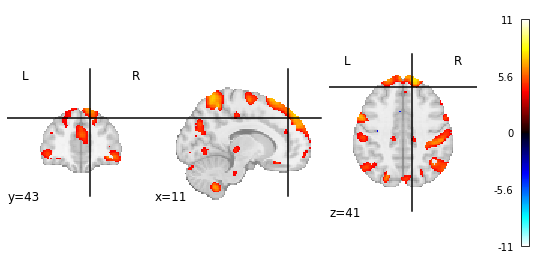

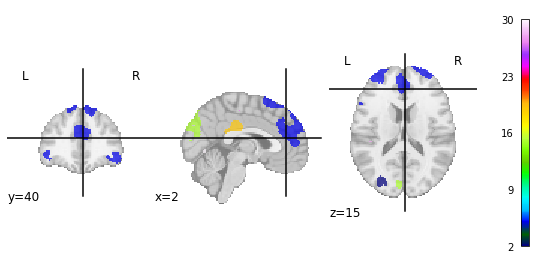

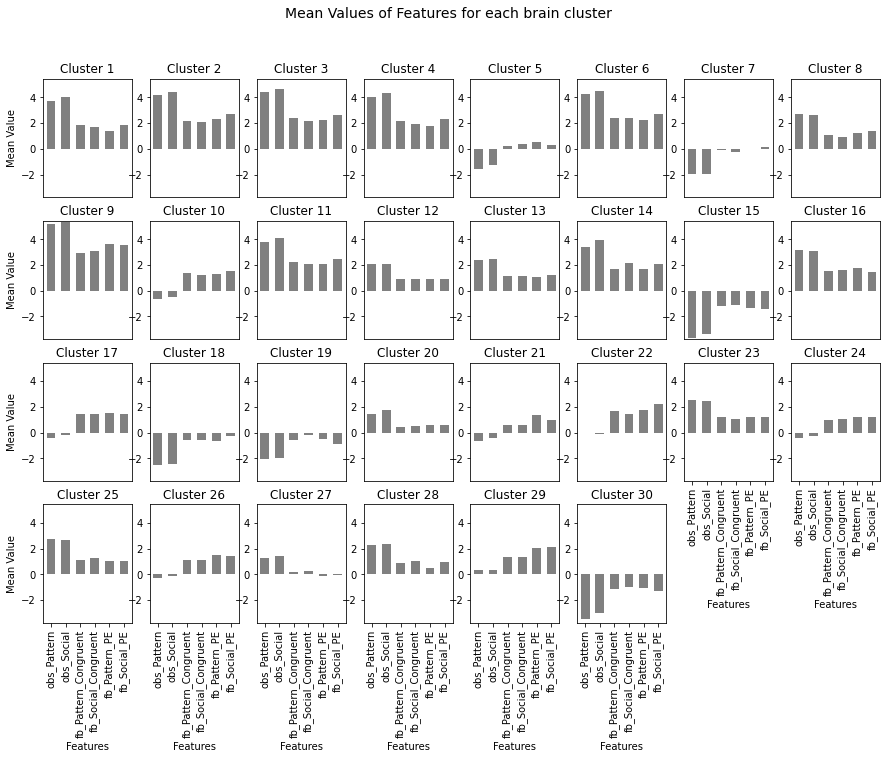

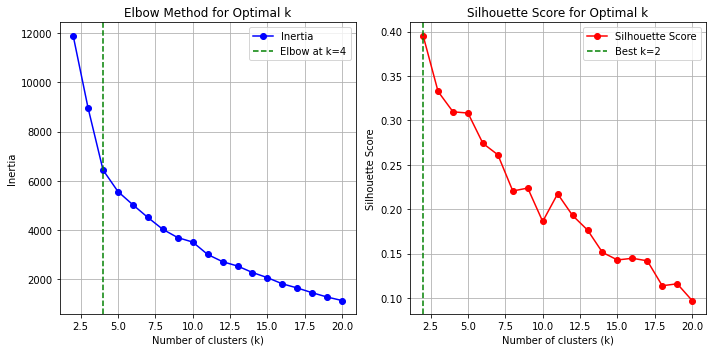

Best k by Elbow method: 4
Best k by Silhouette method: 2


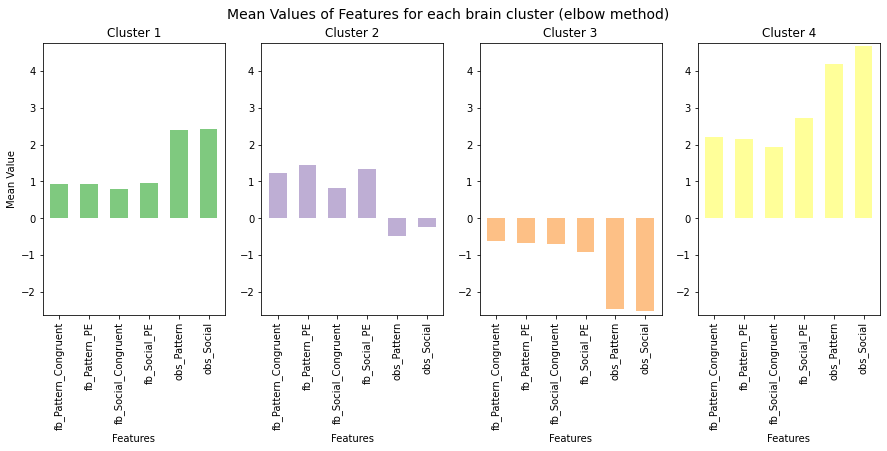

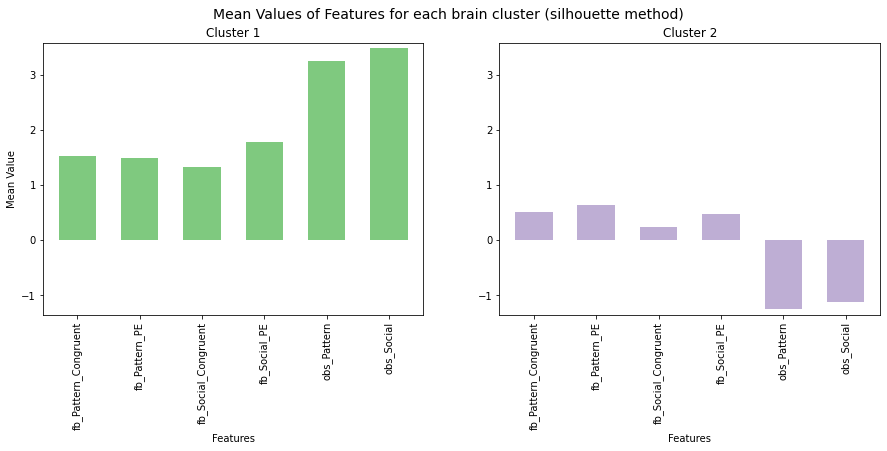

saving fdr_Cluster_elbow.nii.gz
saving fdr_Cluster_silhouette.nii.gz
t-statistic for obs_Pattern vs obs_Social: -0.44461864399819034
p-value for obs_Pattern vs obs_Social: 0.6683781195757468
t-statistic for obs_Pattern vs fb_Pattern_Congruent: 14.009405272883438
p-value for obs_Pattern vs fb_Pattern_Congruent: 6.536948930854916e-07
t-statistic for obs_Pattern vs fb_Social_Congruent: 16.624506825926996
p-value for obs_Pattern vs fb_Social_Congruent: 1.7322218848033725e-07
t-statistic for obs_Pattern vs fb_Pattern_PE: 12.822667577723033
p-value for obs_Pattern vs fb_Pattern_PE: 1.291465931015997e-06
t-statistic for obs_Pattern vs fb_Social_PE: 17.63231795482812
p-value for obs_Pattern vs fb_Social_PE: 1.0939877958829995e-07
t-statistic for obs_Social vs fb_Pattern_Congruent: 20.426340258357584
p-value for obs_Social vs fb_Pattern_Congruent: 3.451398204023233e-08
t-statistic for obs_Social vs fb_Social_Congruent: 17.03406297245182
p-value for obs_Social vs fb_Social_Congruent: 1.432648511

,cluster,col_pairs,t_stats,p_vals
1,1.0,obs_Pattern-fb_Pattern_Congruent,14.009405,6.536949e-07
2,1.0,obs_Pattern-fb_Social_Congruent,16.624507,1.732222e-07
3,1.0,obs_Pattern-fb_Pattern_PE,12.822668,1.291466e-06
4,1.0,obs_Pattern-fb_Social_PE,17.632318,1.093988e-07
5,1.0,obs_Social-fb_Pattern_Congruent,20.426340,3.451398e-08
6,1.0,obs_Social-fb_Social_Congruent,17.034063,1.432649e-07
7,1.0,obs_Social-fb_Pattern_PE,16.219885,2.098892e-07
8,1.0,obs_Social-fb_Social_PE,21.887857,2.003070e-08
0,2.0,obs_Pattern-obs_Social,-3.933206,5.652382e-03
1,2.0,obs_Pattern-fb_Pattern_Congruent,-12.394075,5.117298e-06


In [47]:
cluster_colors = ['#7FC97F', '#BEAED4', '#FDC086', '#FFFF99', '#386CB0', '#F0027F', '#BF5B17']
ClusterMeanBetaDF, df_grouped, roi_sub_z_df = run_interpretation_pipeline('fdr',  second_level_res_dir, second_level_input, cluster_threshold=50, color_list=cluster_colors)
res = CalculatePairwiseTTest(df_grouped,  which_cluster = 'Cluster_elbow')
sig_res = res[res['p_vals'] < 0.05]
sig_res

In [10]:
df_grouped.groupby('Cluster_elbow').count()

video,fb_Pattern_Congruent,fb_Pattern_PE,fb_Social_Congruent,fb_Social_PE,obs_Pattern,obs_Social,Cluster_silhouette
Cluster_elbow,,,,,,,
1,9,9,9,9,9,9,9
2,8,8,8,8,8,8,8
3,5,5,5,5,5,5,5
4,8,8,8,8,8,8,8


In [17]:
# save 
df_grouped.to_csv('df_Cluster_elbow.csv')
roi_sub_z_df.to_csv('roi_sub_z_df.csv')

In [58]:
df_grouped

video,fb_Pattern_Congruent,fb_Pattern_PE,fb_Social_Congruent,fb_Social_PE,obs_Pattern,obs_Social,Cluster_elbow,Cluster_silhouette
0,1.840384,1.342071,1.457753,1.891394,3.863946,4.201558,4,1
1,2.121787,2.271282,1.838070,2.865049,4.278081,4.624067,4,1
2,2.443137,2.165233,2.005771,2.850038,4.579098,4.930553,4,1
3,2.162050,1.784690,1.633373,2.538022,4.078210,4.760303,4,1
4,0.379767,0.586071,0.214541,0.218056,-1.508254,-1.331281,2,2
5,2.278023,2.154527,2.153660,2.851554,4.210178,4.779265,4,1
6,-0.052400,-0.076183,-0.485630,0.129661,-2.058596,-1.767930,3,2
7,1.045013,1.287363,0.656293,1.157037,2.664144,2.694043,1,1
8,3.067840,3.765781,2.708606,3.761059,5.306140,5.589848,4,1
9,1.531185,1.361266,0.834309,1.504960,-0.857879,-0.377117,2,2


In [64]:
# transpose the df such that sub_video is column names
df_grouped_transposed = roi_sub_z_df.T
df_grouped_transposed.columns = df_grouped_transposed.iloc[-2]
df_grouped_transposed.drop(df_grouped_transposed.tail(2).index, inplace = True)

# add the cluster labels 

df_grouped_transposed['Cluster_elbow'] = df_grouped['Cluster_elbow']

df_grouped_transposed.groupby('Cluster_elbow').count()

# save
df_grouped_transposed.to_csv('KMeansCluster_bySubVideo_forPlotting.csv')

/Users/yiyuwang/anaconda3/envs/neuroimaging_env/lib/python3.7/site-packages/nilearn/plotting/js_plotting_utils.py:81: UserWarning: vmin cannot be chosen when cmap is symmetric
  warnings.warn('vmin cannot be chosen when cmap is symmetric')
/Users/yiyuwang/anaconda3/envs/neuroimaging_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/yiyuwang/anaconda3/envs/neuroimaging_env/lib/python3.7/site-packages/nilearn/image/resampling.py:591: UserWarning: Casting data from int32 to float32
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")



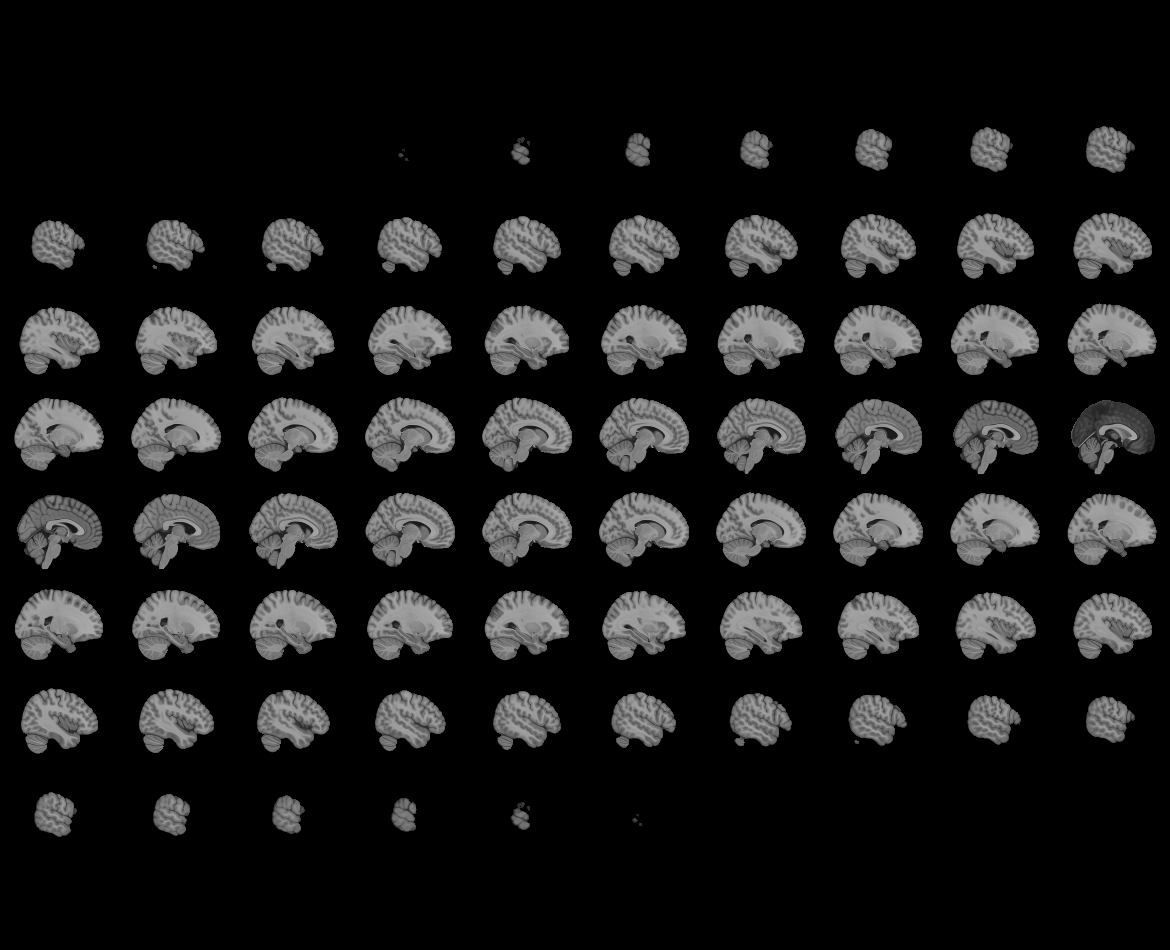
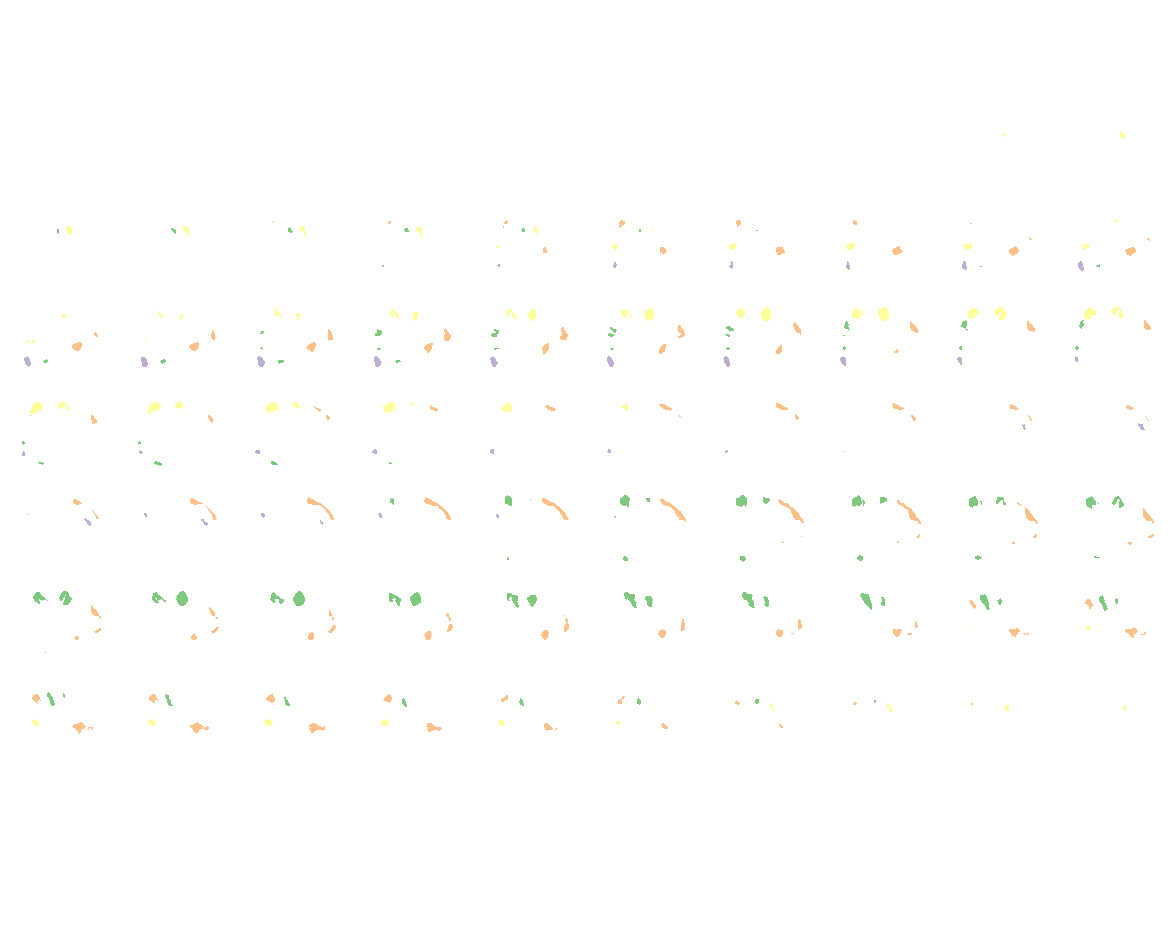

In [14]:
import matplotlib
# plot the four clusters from fdr_elbow_cluster map
elbow_cluster = nib.load(second_level_res_dir + 'bonferroni_Cluster_elbow.nii.gz')
simple_color_padding = ['#FFFFFF', '#FFFFFF', '#FFFFFF', '#FFFFFF', '#FFFFFF']
cluster_colors = ['#7FC97F', '#BEAED4', '#FDC086', '#FFFF99']

my_palette = matplotlib.colors.ListedColormap(simple_color_padding + cluster_colors)

# Plot the clusters using a brain plotting function from Nilearn
# display = plotting.plot_roi(brain_img, cmap=cmap, title="Categorical Cluster Plot", draw_cross=False)


plotting.view_img(elbow_cluster, cmap=my_palette, vmin = 0.1, draw_cross=False, colorbar=True)